In [57]:
# imports here
import json
from tqdm import tqdm
from r1_vlm.environments.real_iad_env.completion_generation import setup_env, setup_model_and_processor, hash_example
import matplotlib.pyplot as plt

In [50]:
def load_completion_dataset(path:str = "/millcreek/home/sunil/r1_vlm/src/r1_vlm/environments/real_iad_env/completion_results/completion_results.jsonl"):
    '''
    Loads the completion dataset from the given path. Returns a dictionary of examples, mapping the image hash to the highest scoring completion for that image.
    '''
    
    data = []
    with open(path, "r") as f:
        for line in tqdm(f):
            data.append(json.loads(line.strip()))
    
    # maps the image hash to the examples that have that hash to organize the data
    hash_to_examples = {}
    
    for example in data:
        hash_value = example["image_hash"]
        
        if hash_value not in hash_to_examples:
            hash_to_examples[hash_value] = []
        
        hash_to_examples[hash_value].append(example)
    
    
    filtered_data = {}
        
    # only keep the top scoring completion for each image
    for hash_value, examples in hash_to_examples.items():
        examples.sort(key=lambda x: x["reward"], reverse=True)
        filtered_data[hash_value] = examples[0]

    return filtered_data

In [52]:
completion_dataset = load_completion_dataset()

_, processor = setup_model_and_processor(checkpoint_path="/millcreek/home/sunil/r1_vlm/vlm-r1-real-iad-simple-env-budget-forcing-longer-ignore-strings/checkpoint-100")

env = setup_env(processor=processor)
train_dataset, _ = env.get_dataset()

26821it [00:00, 36952.00it/s]


After balancing training split: label
missing parts    385
pit              308
ok               306
scratch          281
contamination    253
Name: count, dtype: int64


In [56]:
# determine how many completions we have per class
counts = {}

for example in tqdm(train_dataset):
    label = example["label"]
    if label not in counts:
        counts[label] = 0
    
    hash_value = hash_example(example)
    if hash_value in completion_dataset:
        counts[label] += 1
   

print(counts)

    

100%|██████████| 1533/1533 [01:04<00:00, 23.84it/s]

{'ok': 27, 'pit': 160, 'scratch': 132, 'missing parts': 195, 'contamination': 121}


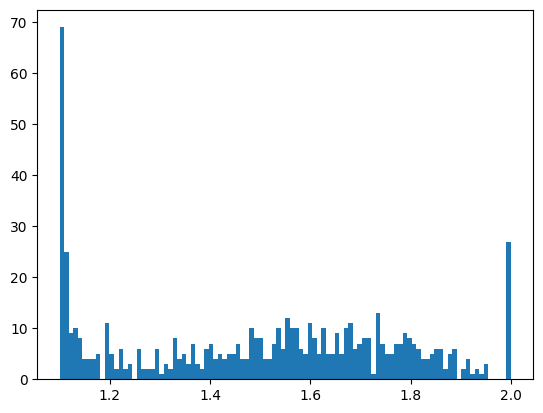

In [58]:
rewards = []
for example in completion_dataset.values():
    rewards.append(example["reward"])

# plot a histogram of the rewards
plt.hist(rewards, bins=100)
plt.show()


In [59]:
# convert the training dataset to a dictionary mapping the image hash to the example so we can look up each example by image hash
train_dataset_hash_to_example = {}
for example in tqdm(train_dataset, desc="Hashing training dataset"):
    hash_value = hash_example(example)
    train_dataset_hash_to_example[hash_value] = example




100%|██████████| 1533/1533 [01:08<00:00, 22.28it/s]


In [72]:
sft_examples = []
for example in completion_dataset.values():
    hash_value = example["image_hash"]
    train_example = train_dataset_hash_to_example[hash_value]
    
    messages = train_example["messages"]
    
    # remove nonsense keys added by huggingface
    for message in messages:
            content = message["content"]
            message["content"] = [
                {k: v for k, v in item.items() if v is not None} for item in content
            ]
    
    # add the assistant's completion to the messages
    completion_message = example["completion_messages"][0]
    
    # if the completion message ends in <|im_end|> then remove it
    if completion_message["content"][0]["text"].endswith("<|im_end|>"):
        completion_message["content"][0]["text"] = completion_message["content"][0]["text"].rstrip("<|im_end|>")
    
    train_example["messages"].append(completion_message)
    
    sft_example = {"messages": train_example["messages"]}
    
    sft_examples.append(sft_example)
    


    




635
